<a href="https://colab.research.google.com/github/adityakpranav/Some-AI-Stuff/blob/master/Copy_of_Copy_of_6_Assignment_NB_Instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Apply NB

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

In [2]:
import warnings
from sys import getsizeof
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# init

from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot as plt
from scipy.sparse import coo_matrix, hstack ,csr_matrix

from sklearn.metrics import roc_curve, auc


## 1.1 Loading Data

In [21]:
data = pd.read_csv('/gdrive/My Drive/AAIC course/6.Apply Naive Bayes on Donors Choose dataset/preprocessed_data.csv',nrows=70000)
print("Imported data")
print(data.shape)

Imported data
(70000, 9)


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>


In [23]:
from sklearn.model_selection import train_test_split

feature_col = ['school_state','teacher_prefix','project_grade_category',
               'clean_categories','clean_subcategories','teacher_number_of_previously_posted_projects',
               'price']
 
#Splitting data

X_train, X_test, y_train, y_test = train_test_split(data[['essay']+feature_col], data['project_is_approved'], test_size=0.10, stratify=data['project_is_approved'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(63000, 8) (63000,)
(7000, 8) (7000,)


In [24]:
X_train

,essay,school_state,teacher_prefix,project_grade_category,clean_categories,clean_subcategories,teacher_number_of_previously_posted_projects,price
45285,my school k 8 science technology engineering m...,nc,mr,grades_6_8,appliedlearning,other,0,164.77
40446,my students tell story school pre recorded vid...,la,mrs,grades_6_8,math_science appliedlearning,appliedsciences charactereducation,5,987.23
14890,my second grade students enthusiastic learners...,tx,mrs,grades_prek_2,literacy_language math_science,literacy mathematics,4,284.91
31014,our community supportive school my students br...,wv,mrs,grades_9_12,math_science,appliedsciences environmentalscience,21,194.93
57360,my students diverse group musicians south san ...,ca,mr,grades_3_5,music_arts specialneeds,music specialneeds,0,89.99
...,...,...,...,...,...,...,...,...
63582,my students walk classroom every day ready lea...,mi,mrs,grades_prek_2,literacy_language math_science,literacy mathematics,0,365.08
47279,baywood elementary amazing safe environment st...,ca,mrs,grades_3_5,literacy_language math_science,literacy mathematics,0,436.97
59521,student engagement interactive learning main t...,ny,ms,grades_6_8,math_science,mathematics,2,286.89
58991,my kinder friends special my students strong d...,in,mrs,grades_prek_2,literacy_language math_science,literature_writing mathematics,0,1874.94


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

<h3>BAG of Words And TFIDF of essay column


In [12]:
# fit
count_vectorizer = CountVectorizer(min_df=10,ngram_range=(1,6), max_features=600)
count_vectorizer.fit(X_train['essay'].values)
# fit
tfidf_vectorizer = TfidfVectorizer(min_df=10,max_features=250)
tfidf_vectorizer.fit(X_train['essay'].values) 



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=250,
                min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [25]:


# Below Lists contains all processed data
X_train_pro_list  = []
X_test_pro_list = []



# transform and store at 0th index in processed array
X_train_pro_list.append(count_vectorizer.transform(X_train['essay'].values))
X_test_pro_list.append(count_vectorizer.transform(X_test['essay'].values))



# transform and store at 1st index in processed array
X_train_pro_list.append(tfidf_vectorizer.transform(X_train['essay'].values))
X_test_pro_list.append(tfidf_vectorizer.transform(X_test['essay'].values))



print("After vectorizations BOW")
#print(X_train["essay_bow"].shape, y_train.shape)
print(X_train_pro_list[-2].shape, y_train.shape)
print(X_test_pro_list[-2].shape, y_test.shape)
print("-"*100)


print("After vectorizations TFIDF")
print(X_train_pro_list[-1].shape, y_train.shape)
print(X_test_pro_list[-1].shape, y_test.shape)
print("-"*100)



After vectorizations BOW
(63000, 600) (63000,)
(7000, 600) (7000,)
----------------------------------------------------------------------------------------------------
After vectorizations TFIDF
(63000, 250) (63000,)
(7000, 250) (7000,)
----------------------------------------------------------------------------------------------------


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 Encode categorical features</h3>

In [14]:

col_for_CountVectorizer = ['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']
CountVectorizer_for_col = {}
for col in col_for_CountVectorizer:
  print(col)
  vectorizer = CountVectorizer()
  vectorizer.fit(X_train[col].values) # fit has to happen only on train data

  CountVectorizer_for_col[col]=vectorizer
  # we use the fitted CountVectorizer to convert the text to vector
  X_train_pro_list.append(vectorizer.transform(X_train[col].values))

  X_test_pro_list.append(vectorizer.transform(X_test[col].values))

  
# convert teacher_number_of_previously_posted_projects int -> str -> count Vect
'''
col = 'teacher_number_of_previously_posted_projects'
vectorizer = CountVectorizer()
vectorizer.fit(X_train[col].astype(str).values) # fit has to happen only on train data

CountVectorizer_for_col[col] = vectorizer


X_train_pro_list.append(vectorizer.transform(X_train[col].astype(str).values))#.toarray()
X_test_pro_list.append(vectorizer.transform(X_test[col].astype(str).values))#.toarray()


'''

school_state
teacher_prefix
project_grade_category
clean_categories
clean_subcategories


"\ncol = 'teacher_number_of_previously_posted_projects'\nvectorizer = CountVectorizer()\nvectorizer.fit(X_train[col].astype(str).values) # fit has to happen only on train data\n\nCountVectorizer_for_col[col] = vectorizer\n\n\nX_train_pro_list.append(vectorizer.transform(X_train[col].astype(str).values))#.toarray()\nX_test_pro_list.append(vectorizer.transform(X_test[col].astype(str).values))#.toarray()\n\n\n"

<h3>1.4.2 Encode numerical valued features</h3>


In [15]:
from sklearn.preprocessing import Normalizer

# convert teacher_number_of_previously_posted_projects int -> Normalised values between 0,1
col = 'teacher_number_of_previously_posted_projects'
normalizer = Normalizer()
normalizer.fit(X_train[col].values.reshape(1,-1))

X_train_pro_list.append(normalizer.transform(X_train[col].values.reshape(1,-1)).reshape(-1,1))

X_test_pro_list.append(normalizer.transform(X_test[col].values.reshape(1,-1)).reshape(-1,1))

print("After teacher_number_of_previously_posted_projects normailzation")
print(X_train_pro_list[-1].shape, y_train.shape)

print(X_test_pro_list[-1].shape, y_test.shape)
print("-"*100)


# Normalize price


col = 'price'
normalizer = Normalizer()
normalizer.fit(X_train[col].values.reshape(1,-1))

X_train_pro_list.append(normalizer.transform(X_train[col].values.reshape(1,-1)).reshape(-1,1))

X_test_pro_list.append(normalizer.transform(X_test[col].values.reshape(1,-1)).reshape(-1,1))

print("After price normailzation")
print(X_train_pro_list[-1].shape, y_train.shape)

print(X_test_pro_list[-1].shape, y_test.shape)
print("-"*100)

After teacher_number_of_previously_posted_projects normailzation
(72000, 1) (72000,)
(8000, 1) (8000,)
----------------------------------------------------------------------------------------------------
After price normailzation
(72000, 1) (72000,)
(8000, 1) (8000,)
----------------------------------------------------------------------------------------------------


In [16]:
all_col = []
for item in range(len(X_train_pro_list)):
  print(X_train_pro_list[item].shape)
  all_col.append(X_train_pro_list[item].shape[1])

# column range 
column_range_tfidf = np.cumsum(all_col[1:])
column_range = np.cumsum([all_col[0]]+all_col[2:])
column_range

(72000, 600)
(72000, 250)
(72000, 51)
(72000, 5)
(72000, 4)
(72000, 9)
(72000, 30)
(72000, 1)
(72000, 1)


array([600, 651, 656, 660, 669, 699, 700, 701])

<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

<h2> HyperParameter tuning


  <h4> Set 1: categorical, numerical features + preprocessed_eassay (BOW)

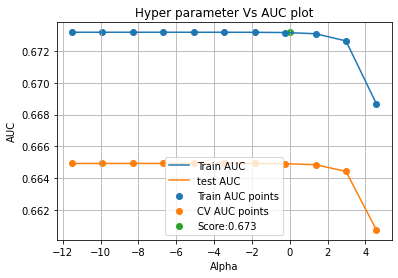

In [26]:

# Stacking all csr matrix in one
# X_train_pro_list[0] --> BOW encoding
# X_train_pro_list[1] --> TFIDF encoding

_X_train_pro_list = hstack(np.array([X_train_pro_list[0]]+X_train_pro_list[2:]))
_X_test_pro_list = hstack(np.array([X_test_pro_list[0]]+X_test_pro_list[2:]))


#Clf dict

model = {}
best_alpha = {}
best_auroc = {}

alpha_param = []
lower_limit = 10e-6
upper_limit = 150
while lower_limit<=upper_limit:
  alpha_param.append(lower_limit)
  lower_limit = lower_limit * 5


parameters = {'alpha':alpha_param}
model['mnb'] = MultinomialNB(class_prior = [0.6, 0.4] )

model['mnb']  = GridSearchCV(model['mnb'], parameters, cv=6, scoring='roc_auc',return_train_score=True)


model['mnb'] .fit(_X_train_pro_list, y_train)

#predictions
results = pd.DataFrame.from_dict(model['mnb'].cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  list(results['param_alpha'])

best_alpha["MultinomialNB_BOW"] = K[train_auc.idxmax()]
best_auroc["MultinomialNB_BOW"] = train_auc.max()

K_log = np.log(K)

plt.plot(K_log, train_auc, label='Train AUC')

plt.plot(K_log, cv_auc, label='test AUC')

plt.scatter(K_log, train_auc, label='Train AUC points')
plt.scatter(K_log, cv_auc, label='CV AUC points')
plt.scatter([best_alpha["MultinomialNB_BOW"]],[train_auc.max()],label='Score:%.3f'%(train_auc.max()))


plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#results.head()

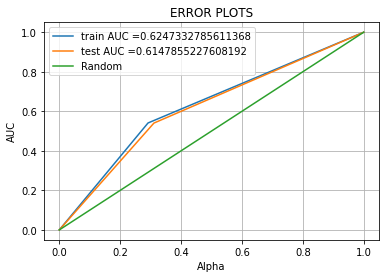

In [18]:
# AUC ROC Curve

# model['mnb'] = MultinomialNB(alpha = best_alpha["MultinomialNB_BOW"],class_prior = [0.5, 0.5] )
mnb_bow = model['mnb'].best_estimator_
mnb_bow.fit(_X_train_pro_list, y_train)


y_train_pred = mnb_bow.predict(_X_train_pro_list)    
y_test_pred = mnb_bow.predict(_X_test_pro_list)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

best_alpha["MultinomialNB_BOW"] = mnb_bow.alpha
best_auroc["MultinomialNB_BOW"] = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],label= "Random")
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

import seaborn as sns
import matplotlib.pyplot as plt     

# Confusion matrix 
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)),linewidths=.5,cmap="YlGnBu", annot=True,fmt="d")


<h4>Set 2: categorical, numerical features + preprocessed_eassay (TFIDF)
    


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
 
# Stacking all csr matrix in one
# X_train_pro_list[0] --> BOW encoding
# X_train_pro_list[1] --> TFIDF encoding

_X_train_pro_list = hstack(np.array(X_train_pro_list[1:]))
_X_test_pro_list = hstack(np.array(X_test_pro_list[1:]))



#Clf dict

model['mnb_tfidf'] = MultinomialNB(class_prior = [0.6, 0.4] )

parameters = {'alpha':alpha_param}

model['mnb_tfidf'] = GridSearchCV(model['mnb_tfidf'], parameters, cv=6, scoring='roc_auc',return_train_score=True)

# essay columns as Tfidf -> essay_tfidf
model['mnb_tfidf'].fit(_X_train_pro_list, y_train)


#predictions

results = pd.DataFrame.from_dict(model['mnb_tfidf'].cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K = list(results['param_alpha'])


best_alpha["MultinomialNB_TFIDF"] = K[train_auc.idxmax()]
best_auroc["MultinomialNB_TFIDF"] = train_auc.max()

K_log = np.log(K)

plt.plot(K_log, train_auc, label='Train AUC')

plt.plot(K_log, cv_auc, label='Test AUC')

plt.scatter( K_log, train_auc, label='Train AUC points')
plt.scatter(K_log, cv_auc, label='Test AUC points')
plt.scatter([best_alpha["MultinomialNB_TFIDF"]],[train_auc.max()],label='train:%.3f'%(train_auc.max()))

plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

mnb_tfidf =  model['mnb_tfidf'].best_estimator_
mnb_tfidf.fit(_X_train_pro_list, y_train)


y_train_pred = mnb_tfidf.predict(_X_train_pro_list)    
y_test_pred = mnb_tfidf.predict(_X_test_pro_list)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

best_alpha["MultinomialNB_TFIDF"] = mnb_tfidf.alpha
best_auroc["MultinomialNB_TFIDF"] = auc(test_fpr, test_tpr)



plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],label= "Random")
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)),linewidths=.5,cmap="YlGnBu", annot=True,fmt="d")

<h3>1.6 Best parameter model

In [ ]:
# credit: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
# Set 1 BOW features 
# array([400, 451, 456, 460, 469, 499, 758, 759])
l = []
l_neg = []


pos_class_prob_sorted = mnb_bow.feature_log_prob_[1].argsort()
neg_class_prob_sorted = mnb_bow.feature_log_prob_[0].argsort()


top_20_Neg_features = neg_class_prob_sorted[-20:]
top_20_features = pos_class_prob_sorted[-20:]

#print("Positive class : Max Encoded : %d,  Min Encoded: %d"%(top_20_features.max(),top_20_features.min()))
#print("Negative class : Max Encoded : %d,  Min Encoded: %d"%(top_20_Neg_features.max(),top_20_Neg_features.min()))
#print(column_range)

col_for_CountVectorizer.append('teacher_number_of_previously_posted_projects')

for item in top_20_features:
  base = column_range[0]
  if item < base:
    l.append(count_vectorizer.get_feature_names()[item])
  elif item >  column_range[-2]:
    l.append("*PRICE")
  else:
      
    feature_index = 1
    while item >= column_range[feature_index]: 
      
      base = column_range[feature_index]
      feature_index+=1

    #print(CountVectorizer_for_col)
    l.append(CountVectorizer_for_col[col_for_CountVectorizer[feature_index-1]].get_feature_names()[item-base])

for item in top_20_Neg_features:
  base = column_range[0]
  if item < base:
    l_neg.append(count_vectorizer.get_feature_names()[item])
  elif item >  column_range[-2]:
    l_neg.append("*PRICE")
  elif item >  column_range[-3]:
    l_neg.append("*teacher_number_of_previously_posted_projects")
  else:
      
    feature_index = 1
    while item >= column_range[feature_index]: 
      
      base = column_range[feature_index]
      feature_index+=1

    #print(CountVectorizer_for_col)
    l_neg.append(CountVectorizer_for_col[col_for_CountVectorizer[feature_index-1]].get_feature_names()[item-base])


print("Top 20 Positive Features:")
print(l)


print("Top 20 Negative Features:")
print(l_neg)


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [ ]:
from tabulate import tabulate
header = ["Vectorizer","Model","Hyper Parameter","AUROC"]
table = [[item[0][0].split('_')[1],item[0][0].split('_')[0],item[0][1],round(item[1],2)] for item in zip(best_alpha.items(),best_auroc.values())]
print(tabulate(table, headers=header))


**THE END**